In [45]:
import cv2
import numpy as np
import PIL
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid
import imutils


In [46]:
def showImage(image, figsize=(15, 15)):
    plt.figure(figsize=figsize)
    plt.imshow(imutils.opencv2matplotlib(image))
    plt.xticks([])
    plt.yticks([])
    plt.show()


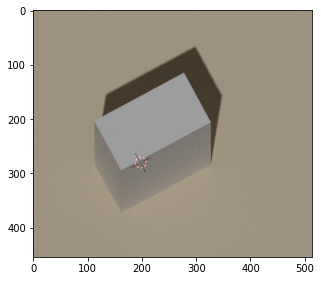

In [47]:
image = cv2.imread("../images/dummy.jpg")
plt.figure(figsize=(5, 5))
plt.imshow(imutils.opencv2matplotlib(image))
plt.show()


From above Calculation, we can see that at this zoom level _(which is actually much higher than what we want)_ every pixel diviation would result in around 0.256 meters of difference in measurment. deviation of 4 pixels could measurments by around a whole meter.


# Creating Polygons for each side


In [48]:
roof = np.array(
    [
        [112, 276, 328, 163],
        [203, 115, 206, 293],
    ]
)

side1 = np.array(
    [
        [112, 163, 161, 113],
        [203, 293, 372, 278],
    ]
)

side2 = np.array(
    [
        [
            163,
            328,
            328,
            161,
        ],
        [
            293,
            206,
            283,
            372,
        ],
    ]
)

shadow = np.array(
    [
        [328, 328, 276, 128, 135, 298, 349],
        [283, 206, 115, 195, 154, 66, 156],
    ]
)


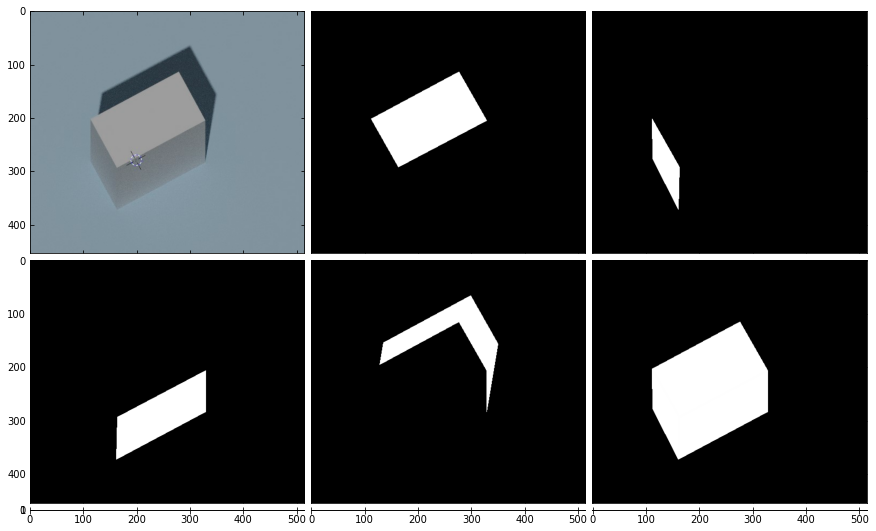

In [49]:
blank = np.zeros_like(image)

seg_roof = cv2.fillPoly(blank.copy(), [roof.T], (255, 255, 255))
seg_side1 = cv2.fillPoly(blank.copy(), [side1.T], (255, 255, 255))
seg_side2 = cv2.fillPoly(blank.copy(), [side2.T], (255, 255, 255))
seg_shadow = cv2.fillPoly(blank.copy(), [shadow.T], (255, 255, 255))

full_poly = seg_roof + seg_side1 + seg_side2

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.1)

for ax, im in zip(grid, [image, seg_roof, seg_side1, seg_side2, seg_shadow, full_poly]):
    ax.imshow(im)

plt.show()


In [50]:
pts1 = [*side1.T, side1.T[0]]
pts2 = [*side2.T, side2.T[0]]

d1 = np.array(
    sorted([np.sqrt(np.sum((a - b) ** 2)) for a, b in zip(pts1[:-1], pts1[1:])])
)
d2 = np.array(
    sorted([np.sqrt(np.sum((a - b) ** 2)) for a, b in zip(pts2[:-1], pts2[1:])])
)

diff = np.abs(np.subtract(d1, d2)) <= 5

final_pts = [*d1[diff], *d2[diff]]
print(f"{np.mean(final_pts):.3f} pixels")


77.514 pixels


In [51]:
print(roof, side1, side2, sep="\n")


[[112 276 328 163]
 [203 115 206 293]]
[[112 163 161 113]
 [203 293 372 278]]
[[163 328 328 161]
 [293 206 283 372]]


In [52]:
IMAGE_SCALE = 80 / (336 - 24)

print(f"distance of one pixel ==> {IMAGE_SCALE:.3f} meters")


distance of one pixel ==> 0.256 meters


(486, 1, 2)


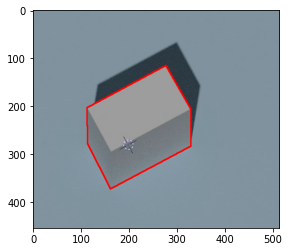

In [53]:
contours = cv2.findContours(full_poly[:, :, 0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(contours[0][0].shape)

cv2.drawContours(image, contours[0], -1, (255, 0, 0), 2)
plt.imshow(image)
plt.show()

# This method probably does not work. Too many points for me to do anything with. can't really do much of anything to extract lines.


[276.3122  114.54489]
[111.57327 202.63144]
[328.4275  283.36853]
[160.68889 372.45374]


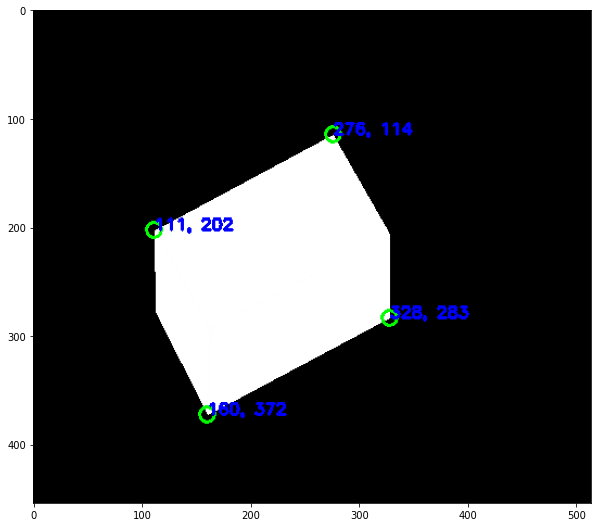

In [80]:
gray_poly = cv2.cvtColor(full_poly, cv2.COLOR_BGR2GRAY)

copy = full_poly.copy()

gray = np.float32(gray_poly)
dst = cv2.cornerHarris(gray, 5, 3, 0.04)
ret, dst = cv2.threshold(dst, 0.1 * dst.max(), 255, 0)
dst = np.uint8(dst)
# dst = cv2.dilate(dst, None)

ret, label, stats, centroids = cv2.connectedComponentsWithStats(dst)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)

corners = cv2.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria)

for i in range(1, len(corners)):
    print(corners[i])
    cv2.circle(copy, (int(corners[i, 0]), int(corners[i, 1])), 7, (0, 255, 0), 2)

    text_string = f"{int(corners[i, 0])}, {int(corners[i, 1])}"
    
    cv2.putText(
        copy,
        text_string,
        (int(corners[i, 0]), int(corners[i, 1])),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 0, 255),
        2
    )

# full_poly[dst > 0.1 * dst.max()] = [0, 255, 0]
plt.figure(figsize=(10, 10))
plt.imshow(copy)
plt.show()


In [55]:
contours, _ = cv2.findContours(full_poly[:, :, 0], cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
polygons = []

for object in contours:
    coords = []

    for point in object:
        coords.append(int(point[0][0]))
        coords.append(int(point[0][1]))

    polygons.append(coords)

len(polygons[0]) / 2


668.0

In [56]:
def cluster_thresholding(
    image, threshold=500, rank=3, connectivity=3, print_info=False
):
    """
    Discard clusters of a a 'binary volume' based on the provided threshold

    inputs:
        image: the input 3D volume
        threshold: a size threshold (should be 10k for HGG, 3k for LGG)
        rank: dimensions of target (default=3)
        connectivity: neighbourhood (default=2)
        print_info: print component sizes (default=False)
    outputs:
        out_image: the output volume

    NOTE: if `threshold=None`, two largest clusters are returned

    Example:
    >> out = cluster_thresholding(inp, threshold=10000, rank=3, connectivity=4)
    """

    structuring_element = ndimage.generate_binary_structure(rank, connectivity)
    labeled_array, numpatches = ndimage.label(
        image, structuring_element
    )  # labeling in accordance with neighbourhood
    sizes = ndimage.sum(
        image, labeled_array, range(1, numpatches + 1)
    )  # sum like-labels
    sizes_list = [sizes[i] for i in range(len(sizes))]  # convert to list
    sizes_list.sort()

    if print_info:
        print("component size", sizes_list)

    if (
        len(sizes) == 0 or len(sizes) == 1
    ):  # image contains only single label (fully connected)
        out_image = image
        print(">>>>>>> Image contains single region >>>>>>>>>>>>>>>>")

    else:
        if threshold:
            out_image = np.zeros_like(image)
            for temp_size in sizes_list:
                if temp_size > threshold:
                    print(temp_size)
                    temp_lab = (
                        np.where(sizes == temp_size)[0] + 1
                    )  # np.where returns a tuple of ndarrays (only condition is given)
                    temp_cmp = labeled_array == temp_lab
                    out_image = (out_image + temp_cmp) > 0
            return out_image  # return labels of regions where quantity > threshold

        else:
            print(">>>>>>> Thresholding>>>>>>>>>>>>>>>>", threshold)
            max_size1 = sizes_list[-1]  # Highest occurence
            # max_size2 = sizes_list[-2]      # 2nd Highest occurence
            max_label1 = np.where(sizes == max_size1)[0] + 1
            # max_label2 = np.where(sizes == max_size2)[0] + 1
            component1 = labeled_array == max_label1
            # component2 = labeled_array == max_label2

            # if max_size2*10 > max_size1:
            #    component1 = (component1 + component2) > 0
            out_image = (
                component1  # return regions of highest and 2nd highest population
            )

    return out_image
